In [50]:
from pandasql import sqldf
import pandas as pd
pysqldf = lambda q: sqldf(q, globals())
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression


wr_data = pd.read_csv('wr_data.csv')
rb_data = pd.read_csv('rb_data.csv')
te_data = pd.read_csv('te_data.csv')
qb_data = pd.read_csv('qb_data.csv')
print(wr_data.columns)

Index(['Player', 'Year', 'ADP', 'Fantasy_Round', 'Position_ADP',
       'Positional_Rank', 'Overall_Rank', 'Returned_Value_Overall',
       'Returned_Value_Postition', 'College', 'Conference',
       'College_Wins_Final_Szn', 'Draft_Position', 'Draft_Round',
       'Team_Drafted_To', 'Team_Drafted_to_Ws_Prev_Yr', 'Receptions', 'Yards',
       'TDS'],
      dtype='object')


In [ ]:
query = """
SELECT 
    Player, Year, ADP, Fantasy_Round, Position_ADP, Positional_Rank, 
    Overall_Rank, Returned_Value_Overall, Returned_Value_Postition,
    College, Conference, College_Wins_Final_Szn, Draft_Position, 
    Draft_Round, Team_Drafted_To, Team_Drafted_to_Ws_Prev_Yr, 
    Yards, TDS, 
    Carries AS Specific_Metric
FROM rb_data
UNION ALL
SELECT 
    Player, Year, ADP, Fantasy_Round, Position_ADP, Positional_Rank, 
    Overall_Rank, Returned_Value_Overall, Returned_Value_Postition,
    College, Conference, College_Wins_Final_Szn, Draft_Position, 
    Draft_Round, Team_Drafted_To, Team_Drafted_to_Ws_Prev_Yr, 
    Yards, TDS, 
    Receptions AS Specific_Metric
FROM wr_data;
"""
combined_df = pysqldf(query)

combined_df.head()

,Player,Year,ADP,Fantasy_Round,Position_ADP,Positional_Rank,Overall_Rank,Returned_Value_Overall,Returned_Value_Postition,College,Conference,College_Wins_Final_Szn,Draft_Position,Draft_Round,Team_Drafted_To,Team_Drafted_to_Ws_Prev_Yr,Yards,TDS,Specific_Metric
0,Derrick Henry,2016,91,8,34,46,170,0,0,Alabama,SEC,14,45,2,Tenessee,3,2219,28,395
1,Melvin Gordon,2015,34,3,15,50,163,0,0,Wisconsin,Big 10,11,15,1,SanDiego/Los Angeles Chargers,4,2587,29,343
2,Jonathan Taylor,2020,43,4,21,6,34,1,1,Wisconsin,Big 10,10,41,2,Indianapolis,7,2003,21,320
3,A.J. Dillon,2020,167,14,54,82,311,0,0,Boston College,ACC,6,62,2,Green Bay,13,1685,14,318
4,David Cobb,2015,146,13,50,104,337,0,0,Minnesota,Big 10,8,138,5,Tenessee,2,1626,13,314


In [8]:
# Finding the percent that return value by conference to see if its better to draft from a specific conference
# This cell is WRs, cell below is RBs

wr_conference_return = pysqldf("""
SELECT 
    CASE 
        WHEN Conference IN ('Big 12', 'Big 10', 'ACC', 'Pac-12', 'SEC') THEN Conference
        ELSE 'Other'
    END AS Conference_Category,
    AVG(Returned_Value_Postition) * 100 AS Avg_Returned_Value_Percentage
FROM wr_data
GROUP BY Conference_Category
""")

wr_conference_return

,Conference_Category,Avg_Returned_Value_Percentage
0,ACC,25.000000
1,Big 10,50.000000
2,Big 12,33.333333
3,Other,9.090909
4,Pac-12,50.000000
5,SEC,55.555556


In [9]:
rb_conference_return = pysqldf("""
SELECT 
    CASE 
        WHEN Conference IN ('Big 12', 'Big 10', 'ACC', 'Pac-12', 'SEC') THEN Conference
        ELSE 'Other'
    END AS Conference_Category,
    AVG(Returned_Value_Postition) * 100 AS Avg_Returned_Value_Percentage
FROM rb_data
GROUP BY Conference_Category
""")

rb_conference_return

,Conference_Category,Avg_Returned_Value_Percentage
0,ACC,57.142857
1,Big 10,54.545455
2,Big 12,41.666667
3,Other,44.444444
4,SEC,50.000000


In [10]:
combined_conference_return = pysqldf("""
SELECT 
    CASE 
        WHEN Conference IN ('Big 12', 'Big 10', 'ACC', 'Pac-12', 'SEC') THEN Conference
        ELSE 'Other'
    END AS Conference_Category,
    AVG(Returned_Value_Postition) * 100 AS Avg_Returned_Value_Percentage
FROM combined_df
GROUP BY Conference_Category
""")

combined_conference_return

,Conference_Category,Avg_Returned_Value_Percentage
0,ACC,45.454545
1,Big 10,52.631579
2,Big 12,38.888889
3,Other,31.034483
4,Pac-12,50.000000
5,SEC,52.500000


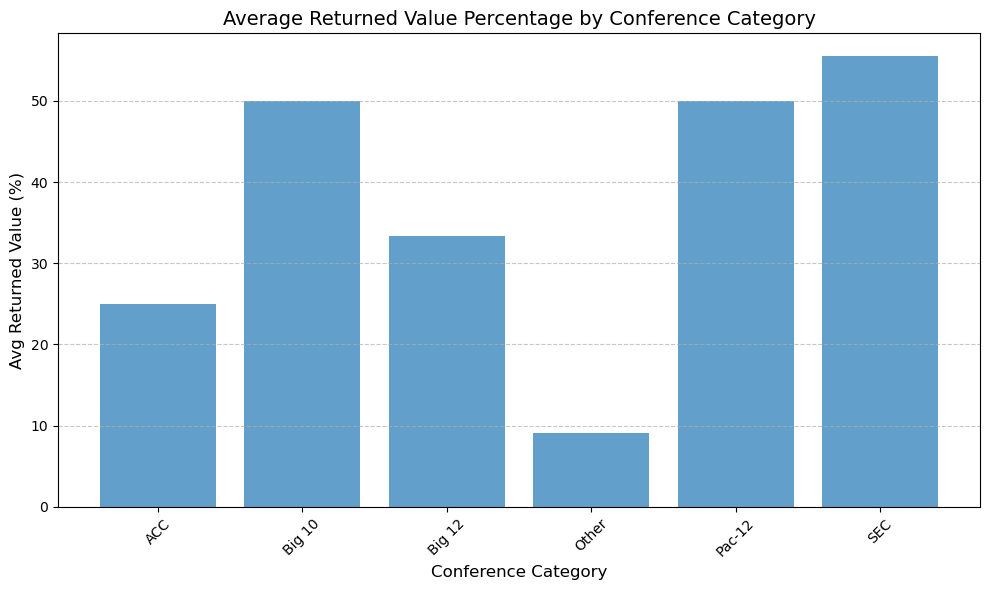

In [13]:

conference_wr_categories = wr_conference_return['Conference_Category']
avg_wr_returned_values = wr_conference_return['Avg_Returned_Value_Percentage']

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(conference_wr_categories, avg_wr_returned_values, alpha=0.7)

# Customize the chart
plt.title('Average Returned Value Percentage by Conference Category', fontsize=14)
plt.xlabel('Conference Category', fontsize=12)
plt.ylabel('Avg Returned Value (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.tight_layout()
plt.show()



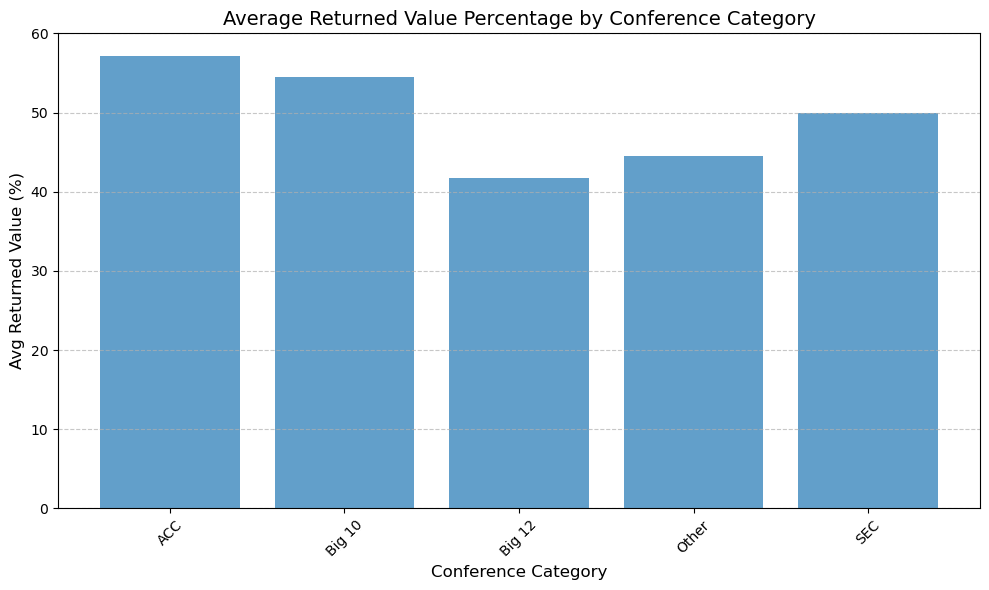

In [14]:

conference_rb_categories = rb_conference_return['Conference_Category']
avg_rb_returned_values = rb_conference_return['Avg_Returned_Value_Percentage']

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(conference_rb_categories, avg_rb_returned_values, alpha=0.7)

# Customize the chart
plt.title('Average Returned Value Percentage by Conference Category', fontsize=14)
plt.xlabel('Conference Category', fontsize=12)
plt.ylabel('Avg Returned Value (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.tight_layout()
plt.show()


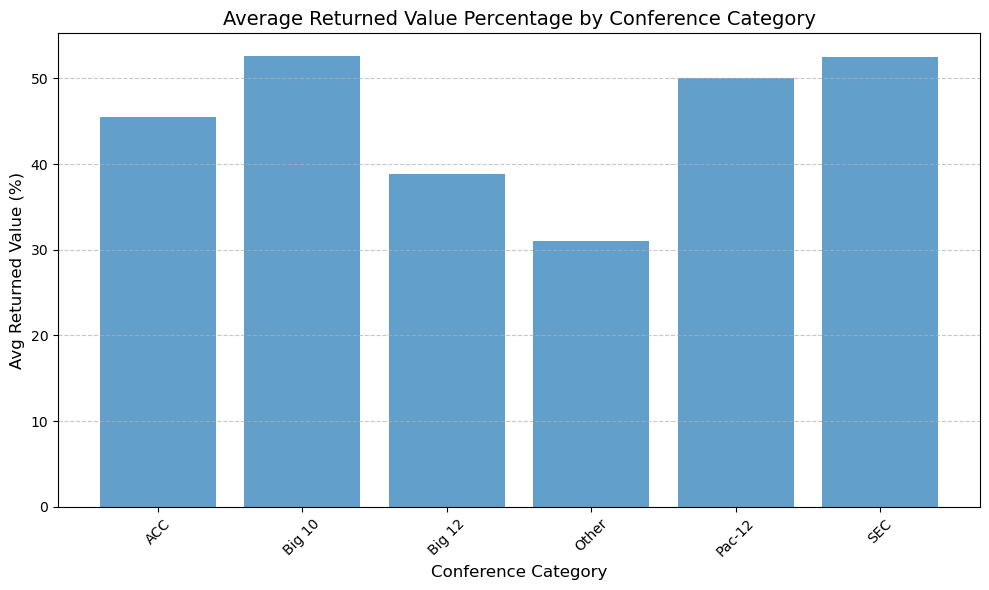

In [15]:
conference_tot_categories = combined_conference_return['Conference_Category']
avg_tot_returned_values = combined_conference_return['Avg_Returned_Value_Percentage']

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(conference_tot_categories, avg_tot_returned_values, alpha=0.7)

# Customize the chart
plt.title('Average Returned Value Percentage by Conference Category', fontsize=14)
plt.xlabel('Conference Category', fontsize=12)
plt.ylabel('Avg Returned Value (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the chart
plt.tight_layout()
plt.show()

In [19]:
# Finding the average difference between position adp and ending rank based on those who return value and those who dont
# Essentially when they hit how much do they exceed expectations and when they miss how much do they miss expectations by
# This cell is for WRs, cell below is RBs

wr_return_diff = pysqldf("""
SELECT 
    CASE 
        WHEN Returned_Value_Postition = 1 THEN 'Returned Value' 
        ELSE 'Did Not Return Value' 
    END AS Return_Status,
    AVG(Position_ADP - Positional_Rank) AS Avg_Positional_Difference
FROM wr_data
GROUP BY Return_Status;
""")
wr_return_diff

,Return_Status,Avg_Positional_Difference
0,Did Not Return Value,-60.9375
1,Returned Value,17.0000


In [18]:
rb_return_diff = pysqldf("""
SELECT 
    CASE 
        WHEN Returned_Value_Postition = 1 THEN 'Returned Value' 
        ELSE 'Did Not Return Value' 
    END AS Return_Status,
    AVG(Position_ADP - Positional_Rank) AS Avg_Positional_Difference
FROM rb_data
GROUP BY Return_Status;
""")
rb_return_diff

,Return_Status,Avg_Positional_Difference
0,Did Not Return Value,-26.750000
1,Returned Value,13.382353


In [ ]:
combined_return_diff = pysqldf("""
SELECT 
    CASE 
        WHEN Returned_Value_Postition = 1 THEN 'Returned Value' 
        ELSE 'Did Not Return Value' 
    END AS Return_Status,
    AVG(Position_ADP - Positional_Rank) AS Avg_Positional_Difference
FROM combined_df
GROUP BY Return_Status;
""")
combined_return_diff

,Return_Status,Avg_Positional_Difference
0,Did Not Return Value,-42.838235
1,Returned Value,14.763636


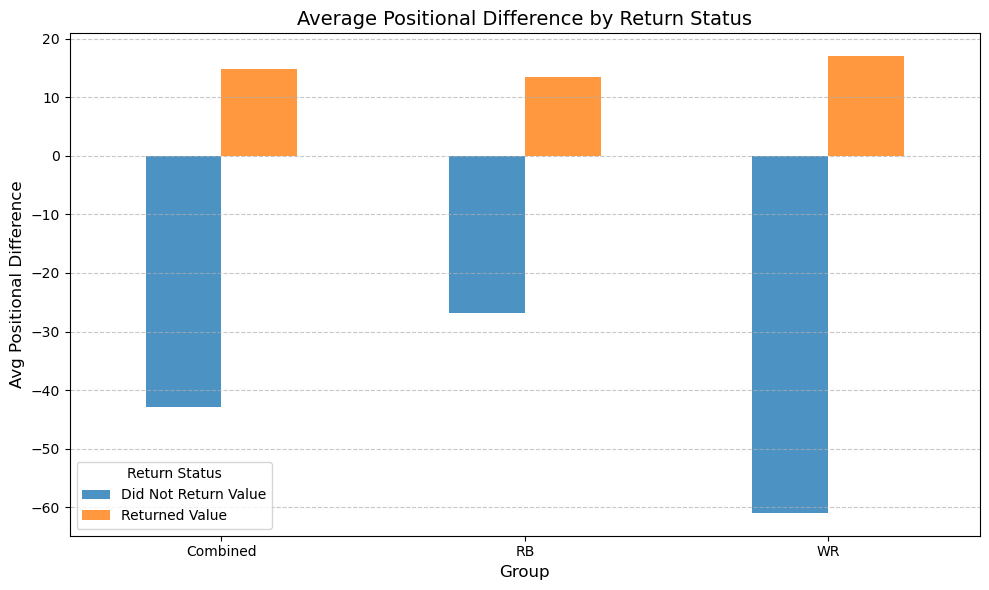

In [23]:
wr_return_diff['Group'] = 'WR'
rb_return_diff['Group'] = 'RB'
combined_return_diff['Group'] = 'Combined'

# Combine all results into a single dataframe
all_results = pd.concat([wr_return_diff, rb_return_diff, combined_return_diff])

# Pivot the data for grouped bar chart plotting
pivot_data = all_results.pivot(index='Group', columns='Return_Status', values='Avg_Positional_Difference')

# Plot a clustered bar chart
pivot_data.plot(kind='bar', figsize=(10, 6), alpha=0.8)

# Customize the chart
plt.title('Average Positional Difference by Return Status', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Avg Positional Difference', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Return Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [36]:
conference_return_diff = pysqldf( """
SELECT 
    CASE 
        WHEN Conference IN ('Big 12', 'Big 10', 'ACC', 'Pac-12', 'SEC') THEN Conference
        ELSE 'Other'
    END AS Conference_Category,
    CASE 
        WHEN Returned_Value_Postition = 1 THEN 'Returned Value'
        ELSE 'Did Not Return Value'
    END AS Return_Status,
    AVG(Position_ADP - Positional_Rank) AS Avg_Positional_Difference
FROM combined_df
WHERE Player != 'John Ross' -- Exclude John Ross
GROUP BY Conference_Category, Return_Status
""")
conference_return_diff

,Conference_Category,Return_Status,Avg_Positional_Difference
0,ACC,Did Not Return Value,-32.500000
1,ACC,Returned Value,13.800000
2,Big 10,Did Not Return Value,-30.111111
3,Big 10,Returned Value,15.000000
4,Big 12,Did Not Return Value,-27.181818
5,Big 12,Returned Value,9.571429
6,Other,Did Not Return Value,-24.700000
7,Other,Returned Value,18.111111
8,Pac-12,Did Not Return Value,-45.000000
9,Pac-12,Returned Value,16.333333


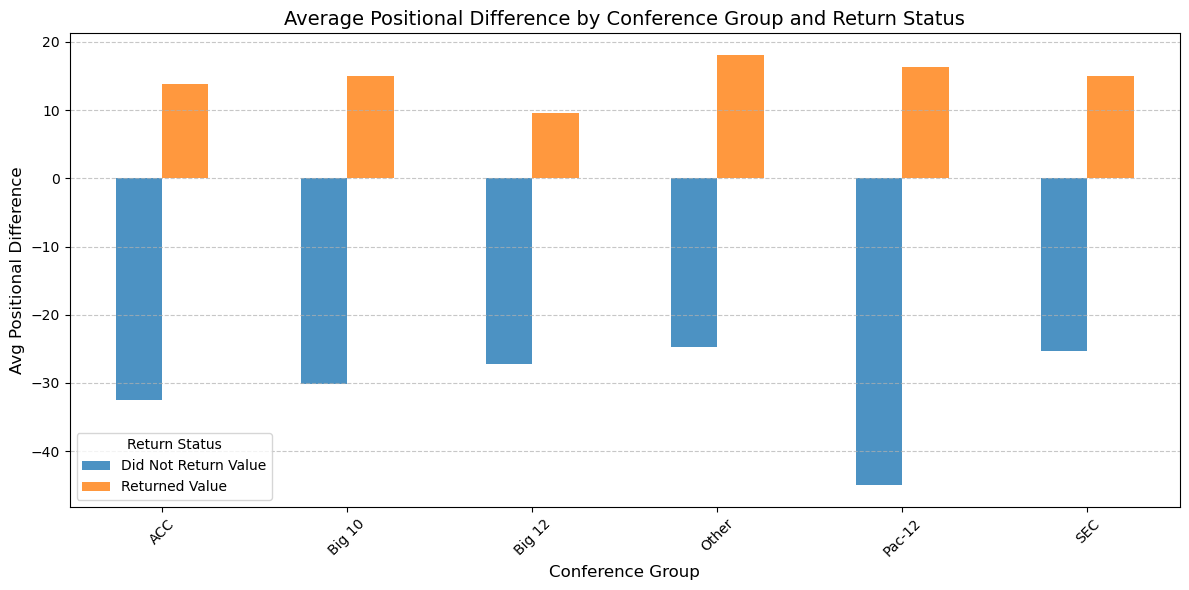

In [37]:
pivot_data = conference_return_diff.pivot(
    index='Conference_Category', 
    columns='Return_Status', 
    values='Avg_Positional_Difference'
)

# Plot the data
pivot_data.plot(kind='bar', figsize=(12, 6), alpha=0.8)

# Customize the chart
plt.title('Average Positional Difference by Conference Group and Return Status', fontsize=14)
plt.xlabel('Conference Group', fontsize=12)
plt.ylabel('Avg Positional Difference', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Return Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [26]:
# Finding the % that return value based on how good the situation they are going into is

wr_situation = pysqldf("""
SELECT 
    CASE 
        WHEN Team_Drafted_to_Ws_Prev_Yr < 5 THEN 'Less than 5 Wins'
        WHEN Team_Drafted_to_Ws_Prev_Yr BETWEEN 5 AND 10 THEN '5-10 Wins'
        ELSE 'Over 10 Wins'
    END AS Wins_Bucket,
    AVG(Returned_Value_PosTition) * 100 AS Avg_Returned_Value_Percentage
FROM wr_data
GROUP BY Wins_Bucket
""")

wr_situation

,Wins_Bucket,Avg_Returned_Value_Percentage
0,5-10 Wins,37.500000
1,Less than 5 Wins,66.666667
2,Over 10 Wins,25.000000


In [27]:
rb_situation = pysqldf("""
SELECT 
    CASE 
        WHEN Team_Drafted_to_Ws_Prev_Yr < 5 THEN 'Less than 5 Wins'
        WHEN Team_Drafted_to_Ws_Prev_Yr BETWEEN 5 AND 10 THEN '5-10 Wins'
        ELSE 'Over 10 Wins'
    END AS Wins_Bucket,
    AVG(Returned_Value_PosTition) * 100 AS Avg_Returned_Value_Percentage
FROM rb_data
GROUP BY Wins_Bucket
""")
rb_situation

,Wins_Bucket,Avg_Returned_Value_Percentage
0,5-10 Wins,52.777778
1,Less than 5 Wins,58.823529
2,Over 10 Wins,29.411765


In [28]:
combined_situation = pysqldf("""
SELECT 
    CASE 
        WHEN Team_Drafted_to_Ws_Prev_Yr < 5 THEN 'Less than 5 Wins'
        WHEN Team_Drafted_to_Ws_Prev_Yr BETWEEN 5 AND 10 THEN '5-10 Wins'
        ELSE 'Over 10 Wins'
    END AS Wins_Bucket,
    AVG(Returned_Value_PosTition) * 100 AS Avg_Returned_Value_Percentage
FROM combined_df
GROUP BY Wins_Bucket
""")
combined_situation

,Wins_Bucket,Avg_Returned_Value_Percentage
0,5-10 Wins,45.588235
1,Less than 5 Wins,61.538462
2,Over 10 Wins,27.586207


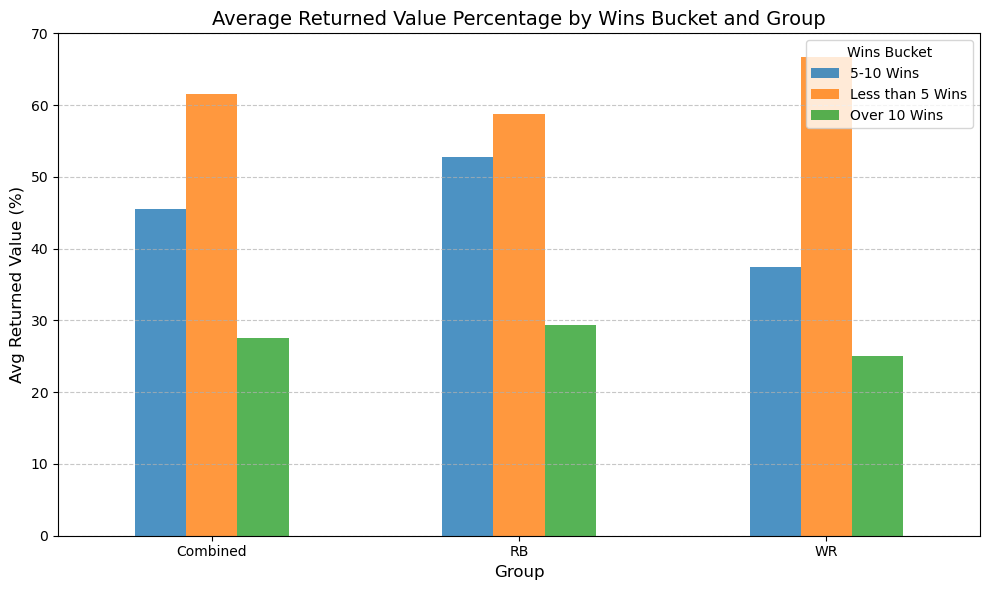

In [29]:
wr_situation['Group'] = 'WR'
rb_situation['Group'] = 'RB'
combined_situation['Group'] = 'Combined'

# Combine all situations into a single dataframe
all_situations = pd.concat([wr_situation, rb_situation, combined_situation])

# Pivot the data for grouped bar chart plotting
pivot_data = all_situations.pivot(index='Group', columns='Wins_Bucket', values='Avg_Returned_Value_Percentage')

# Plot a clustered bar chart
pivot_data.plot(kind='bar', figsize=(10, 6), alpha=0.8)

# Customize the chart
plt.title('Average Returned Value Percentage by Wins Bucket and Group', fontsize=14)
plt.xlabel('Group', fontsize=12)
plt.ylabel('Avg Returned Value (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Wins Bucket')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [67]:
# Grouping value returning by reciever receptions

pysqldf("""
SELECT 
    CASE 
        WHEN Receptions < 60 THEN '<60 Receptions'
        WHEN Receptions BETWEEN 61 AND 75 THEN '61-75 Receptions'
        WHEN Receptions BETWEEN 76 AND 85 THEN '76-85 Receptions'
        WHEN Receptions BETWEEN 86 AND 100 THEN '86-100 Receptions'
        ELSE '100+ Receptions'
    END AS Receptions_Bucket,
    AVG(Returned_Value_PosTition) * 100 AS Avg_Returned_Value_Percentage
FROM wr_data
GROUP BY Receptions_Bucket
""")

,Receptions_Bucket,Avg_Returned_Value_Percentage
0,100+ Receptions,33.333333
1,61-75 Receptions,40.000000
2,76-85 Receptions,28.571429
3,86-100 Receptions,40.000000
4,<60 Receptions,50.000000


In [68]:

pysqldf("""
SELECT 
    CASE 
        WHEN Carries < 150 THEN '<150 Carries'
        WHEN Carries BETWEEN 151 AND 200 THEN '151-200 Carries'
        WHEN Carries BETWEEN 201 AND 250 THEN '201-250 Carries'
        WHEN Carries BETWEEN 251 AND 300 THEN '251-300 Carries'
        ELSE '300+ Yards'
    END AS Carries_Bucket,
    AVG(Returned_Value_PosTition) * 100 AS Avg_Returned_Value_Percentage
FROM rb_data
GROUP BY Carries_Bucket
""")

,Carries_Bucket,Avg_Returned_Value_Percentage
0,151-200 Carries,55.555556
1,201-250 Carries,50.000000
2,251-300 Carries,47.368421
3,300+ Yards,22.222222
4,<150 Carries,58.333333


In [69]:
# Grouping value returning by reciever yards

pysqldf("""
SELECT 
    CASE 
        WHEN Yards < 500 THEN '<500 Yards'
        WHEN Yards BETWEEN 500 AND 750 THEN '500-750 Yards'
        WHEN Yards BETWEEN 750 AND 1000 THEN '750-1000 Yards'
        WHEN Yards BETWEEN 1000 AND 1250 THEN '1000-1250 Yards'
        WHEN Yards BETWEEN 1250 AND 1500 THEN '1250-1500 Yards'
        ELSE '1500+ Yards'
    END AS Yards_Bucket,
    AVG(Returned_Value_PosTition) * 100 AS Avg_Returned_Value_Percentage
FROM wr_data
GROUP BY Yards_Bucket
""")

,Yards_Bucket,Avg_Returned_Value_Percentage
0,1000-1250 Yards,35.714286
1,1250-1500 Yards,16.666667
2,1500+ Yards,57.142857
3,500-750 Yards,33.333333
4,750-1000 Yards,58.333333
5,<500 Yards,50.000000


In [70]:
pysqldf("""
SELECT 
    CASE 
        WHEN Yards < 1000 THEN '<1000 Yards'
        WHEN Yards BETWEEN 1000 AND 1300 THEN '1000-1300 Yards'
        WHEN Yards BETWEEN 750 AND 1000 THEN '750-1000 Yards'
        WHEN Yards BETWEEN 1301 AND 1600 THEN '1301-1600 Yards'
        WHEN Yards BETWEEN 1601 AND 2000 THEN '1601-2000 Yards'
        ELSE '2001+ Yards'
    END AS rb_Yards_Bucket,
    AVG(Returned_Value_PosTition) * 100 AS Avg_Returned_Value_Percentage
FROM rb_data
GROUP BY rb_Yards_Bucket
""")

,rb_Yards_Bucket,Avg_Returned_Value_Percentage
0,1000-1300 Yards,64.705882
1,1301-1600 Yards,42.105263
2,1601-2000 Yards,40.000000
3,2001+ Yards,33.333333
4,<1000 Yards,50.000000


In [71]:
#Grouping value returning by reciver tds

pysqldf("""
SELECT 
    CASE 
        WHEN TDS BETWEEN 0 AND 5 THEN '0-5 TDs'
        WHEN TDS BETWEEN 6 AND 10 THEN '6-10 TDs'
        WHEN TDS BETWEEN 11 AND 15 THEN '11-15 TDs'
        WHEN TDS BETWEEN 16 AND 20 THEN '16-20 TDs'
        ELSE '20+ TDs'
    END AS TDs_Bucket,
    AVG(Returned_Value_PosTition) * 100 AS Avg_Returned_Value_Percentage
FROM wr_data
GROUP BY TDs_Bucket
""")

,TDs_Bucket,Avg_Returned_Value_Percentage
0,0-5 TDs,41.666667
1,11-15 TDs,43.750000
2,16-20 TDs,37.500000
3,20+ TDs,100.000000
4,6-10 TDs,31.250000


In [72]:
pysqldf("""
SELECT 
    CASE 
        WHEN TDS BETWEEN 1 AND 9 THEN '1-9 TDs'
        WHEN TDS BETWEEN 10 AND 14 THEN '10-14 TDs'
        WHEN TDS BETWEEN 15 AND 19 THEN '15-19 TDs'
        WHEN TDS BETWEEN 20 AND 30 THEN '20-30 TDs'
        ELSE '20+ TDs'
    END AS rb_TDs_Bucket,
    AVG(Returned_Value_PosTition) * 100 AS Avg_Returned_Value_Percentage
FROM rb_data
GROUP BY rb_TDs_Bucket
""")

,rb_TDs_Bucket,Avg_Returned_Value_Percentage
0,1-9 TDs,60.000000
1,10-14 TDs,47.619048
2,15-19 TDs,36.842105
3,20-30 TDs,50.000000


In [73]:
#Grouping by draft round

pysqldf("""
SELECT 
    Draft_Round,
    AVG(Returned_Value_Postition) * 100 AS Avg_Returned_Value_Percentage
FROM wr_data
GROUP BY Draft_Round
""")

,Draft_Round,Avg_Returned_Value_Percentage
0,1,44.444444
1,2,36.842105
2,3,25.000000
3,5,33.333333


In [75]:
pysqldf("""
SELECT 
    Draft_Round,
    AVG(Returned_Value_Postition) * 100 AS Avg_Returned_Value_Percentage
FROM rb_data
GROUP BY Draft_Round
""")

,Draft_Round,Avg_Returned_Value_Percentage
0,1,53.846154
1,2,36.842105
2,3,44.444444
3,4,70.000000
4,5,83.333333
5,6,0.000000
6,7,0.000000


In [76]:
#Finding the players who exceeded expectations, those who finished 25% above expectations

pysqldf("""
SELECT *
FROM wr_data
WHERE Positional_Rank <= Position_ADP * 0.75;
""")

,Player,Year,ADP,Fantasy_Round,Position_ADP,Positional_Rank,Overall_Rank,Returned_Value_Overall,Returned_Value_Postition,College,Conference,College_Wins_Final_Szn,Draft_Position,Draft_Round,Team_Drafted_To,Team_Drafted_to_Ws_Prev_Yr,Receptions,Yards,TDS
0,Cooper Kupp,2017,132,11,51,24,70,1,1,Eastern Washington,Big Sky,12,69,3,Los Angeles Rams,4,117,1700,17
1,Justin Jefferson,2020,121,11,48,6,23,1,1,LSU,SEC,15,22,1,Minnesota Vikings,10,111,1540,18
2,Ja'Marr Chase,2021,73,7,29,5,16,1,1,LSU,SEC,15,5,1,Cincinnati Bengals,4,84,1780,20
3,Zay Flowers,2023,110,10,46,31,71,1,1,Boston College,ACC,3,22,1,Baltimore Ravens,10,78,1077,12
4,Chris Olave,2022,107,9,44,25,66,1,1,Ohio State,Big 10,11,11,1,New Orleans Saints,9,65,936,13
5,Brandon Aiyuk,2020,163,14,61,35,79,1,1,ASU,Pac-12,8,25,1,San Francisco 49ers,13,65,1192,8
6,CeeDee Lamb,2020,100,9,40,22,54,1,1,Oklahoma,Big 12,12,17,1,Dallas Cowboys,8,62,1327,14
7,Deebo Samuel Sr.,2019,176,15,59,32,85,1,1,South Carolina,SEC,4,36,2,San Francisco 49ers,4,62,882,11
8,Stefon Diggs,2016,98,9,41,30,115,0,1,Maryland,Big 10,7,146,5,Minnesota Vikings,11,62,792,5
9,Jordan Addison,2023,90,8,37,23,58,1,1,USC,Pac-12,11,23,1,Minnesota Vikings,13,59,875,8


In [77]:
pysqldf("""
SELECT *
FROM rb_data
WHERE Positional_Rank <= Position_ADP * 0.75;
""")

,Player,Year,ADP,Fantasy_Round,Position_ADP,Overall_Rank,Positional_Rank,Returned_Value_Overall,Returned_Value_Postition,College,Conference,College_Wins_Final_Szn,Draft_Position,Draft_Round,Team_Drafted_To,Team_Drafted_to_Ws_Prev_Yr,Carries,Yards,TDS
0,Jonathan Taylor,2020,43,4,21,34,6,1,1,Wisconsin,Big 10,10,41,2,Indianapolis,7,320,2003,21
1,J.K. Dobbins,2020,83,7,31,94,23,0,1,Ohio State,Big 10,13,55,2,Baltimore,14,301,2003,21
2,Ezekiel Elliott,2016,8,1,3,5,2,1,1,Ohio State,Big 10,12,4,1,Dallas,4,289,1821,23
3,David Johnson,2015,123,11,45,22,7,1,1,Northern Iowa,Missouri Valley,8,86,3,Arizona,11,287,1553,17
4,Kenneth Walker III,2022,110,10,38,59,18,1,1,Michigan State,Big 10,11,41,2,Seattle,7,263,1636,18
5,Kareem Hunt,2017,38,4,33,9,4,1,1,Toledo,Mid-American,9,86,3,Kansas City,12,262,1475,10
6,Devontae Booker,2016,138,12,49,129,33,1,1,Utah,Pac 12,10,136,5,Denver,9,258,1261,11
7,Najee Harris,2021,15,2,11,18,3,0,1,Alabama,SEC,13,24,1,Pittsburgh,12,251,1456,26
8,Nick Chubb,2018,118,10,43,66,17,1,1,Georgia,SEC,13,35,2,Cleveland,0,223,1345,15
9,Miles Sanders,2019,71,6,31,60,14,1,1,Penn State,Big 10,9,53,2,Philadelphia,9,220,1274,9


In [78]:
#Finding the players who REALLY exceeded expectations, those who finished 50% above expectations
pysqldf("""
SELECT *
FROM wr_data
WHERE Positional_Rank <= Position_ADP * 0.5;
""")

,Player,Year,ADP,Fantasy_Round,Position_ADP,Positional_Rank,Overall_Rank,Returned_Value_Overall,Returned_Value_Postition,College,Conference,College_Wins_Final_Szn,Draft_Position,Draft_Round,Team_Drafted_To,Team_Drafted_to_Ws_Prev_Yr,Receptions,Yards,TDS
0,Cooper Kupp,2017,132,11,51,24,70,1,1,Eastern Washington,Big Sky,12,69,3,Los Angeles Rams,4,117,1700,17
1,Justin Jefferson,2020,121,11,48,6,23,1,1,LSU,SEC,15,22,1,Minnesota Vikings,10,111,1540,18
2,Ja'Marr Chase,2021,73,7,29,5,16,1,1,LSU,SEC,15,5,1,Cincinnati Bengals,4,84,1780,20
3,Michael Thomas,2016,128,11,51,7,30,1,1,Ohio State,Big 10,12,47,2,New Orleans Saints,7,56,781,9
4,Jaylen Waddle,2021,105,9,44,13,36,1,1,Alabama,SEC,13,6,1,Miami Dolphins,10,28,591,4


In [79]:
pysqldf("""
SELECT *
FROM rb_data
WHERE Positional_Rank <= Position_ADP * 0.5;
""")

,Player,Year,ADP,Fantasy_Round,Position_ADP,Overall_Rank,Positional_Rank,Returned_Value_Overall,Returned_Value_Postition,College,Conference,College_Wins_Final_Szn,Draft_Position,Draft_Round,Team_Drafted_To,Team_Drafted_to_Ws_Prev_Yr,Carries,Yards,TDS
0,Jonathan Taylor,2020,43,4,21,34,6,1,1,Wisconsin,Big 10,10,41,2,Indianapolis,7,320,2003,21
1,David Johnson,2015,123,11,45,22,7,1,1,Northern Iowa,Missouri Valley,8,86,3,Arizona,11,287,1553,17
2,Kenneth Walker III,2022,110,10,38,59,18,1,1,Michigan State,Big 10,11,41,2,Seattle,7,263,1636,18
3,Kareem Hunt,2017,38,4,33,9,4,1,1,Toledo,Mid-American,9,86,3,Kansas City,12,262,1475,10
4,Najee Harris,2021,15,2,11,18,3,0,1,Alabama,SEC,13,24,1,Pittsburgh,12,251,1456,26
5,Nick Chubb,2018,118,10,43,66,17,1,1,Georgia,SEC,13,35,2,Cleveland,0,223,1345,15
6,Miles Sanders,2019,71,6,31,60,14,1,1,Penn State,Big 10,9,53,2,Philadelphia,9,220,1274,9
7,Saquon Barkley,2018,7,1,6,2,1,1,1,Penn State,Big 10,11,2,1,New York Giants,3,217,1271,18
8,Nyheim Hines,2018,203,17,60,96,27,1,1,NC State,ACC,9,104,4,Indianapolis,8,197,1112,12
9,Todd Gurley,2015,61,6,27,15,5,1,1,Georgia,SEC,10,10,1,St.Louis/ Los Angeles Rams,6,123,911,9


In [ ]:
#OGI THIS IS QUERY FOR CASE ANALYSIS

pysqldf("""
SELECT *
FROM combined_df
WHERE Positional_Rank <= Position_ADP * 0.5;
""")

,Player,Year,ADP,Fantasy_Round,Position_ADP,Positional_Rank,Overall_Rank,Returned_Value_Overall,Returned_Value_Postition,College,Conference,College_Wins_Final_Szn,Draft_Position,Draft_Round,Team_Drafted_To,Team_Drafted_to_Ws_Prev_Yr,Yards,TDS,Specific_Metric
0,Jonathan Taylor,2020,43,4,21,6,34,1,1,Wisconsin,Big 10,10,41,2,Indianapolis,7,2003,21,320
1,David Johnson,2015,123,11,45,7,22,1,1,Northern Iowa,Missouri Valley,8,86,3,Arizona,11,1553,17,287
2,Kenneth Walker III,2022,110,10,38,18,59,1,1,Michigan State,Big 10,11,41,2,Seattle,7,1636,18,263
3,Kareem Hunt,2017,38,4,33,4,9,1,1,Toledo,Mid-American,9,86,3,Kansas City,12,1475,10,262
4,Najee Harris,2021,15,2,11,3,18,0,1,Alabama,SEC,13,24,1,Pittsburgh,12,1456,26,251
5,Nick Chubb,2018,118,10,43,17,66,1,1,Georgia,SEC,13,35,2,Cleveland,0,1345,15,223
6,Miles Sanders,2019,71,6,31,14,60,1,1,Penn State,Big 10,9,53,2,Philadelphia,9,1274,9,220
7,Saquon Barkley,2018,7,1,6,1,2,1,1,Penn State,Big 10,11,2,1,New York Giants,3,1271,18,217
8,Nyheim Hines,2018,203,17,60,27,96,1,1,NC State,ACC,9,104,4,Indianapolis,8,1112,12,197
9,Todd Gurley,2015,61,6,27,5,15,1,1,Georgia,SEC,10,10,1,St.Louis/ Los Angeles Rams,6,911,9,123


In [45]:
def train_model(data, target_column, features, model_type="random_forest"):
    X = data[features]
    y = data[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    categorical_features = ['Conference']
    numerical_features = [col for col in features if col not in categorical_features]
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ], remainder='passthrough'
    )
    
    model = RandomForestRegressor(random_state=42, n_estimators=100)
    
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Model Performance: RMSE = {rmse:.2f}, R² = {r2:.2f}")

    feature_importances = model.feature_importances_
    feature_names = preprocessor.get_feature_names_out()

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    print("\nFeature Importances:")
    print(feature_importance_df)
    
    return pipeline


In [46]:
wr_features = ['ADP', 'Position_ADP', 'Conference', 'College_Wins_Final_Szn', 
               'Draft_Position', 'Team_Drafted_to_Ws_Prev_Yr', 'Yards', 
               'Receptions', 'TDS']
wr_target = 'Positional_Rank'

wr_model = train_model(wr_data, target_column=wr_target, features=wr_features)

rb_features = ['ADP', 'Position_ADP', 'Conference', 'College_Wins_Final_Szn', 
               'Draft_Position', 'Team_Drafted_to_Ws_Prev_Yr', 'Yards', 
               'Carries', 'TDS']
rb_target = 'Positional_Rank'

rb_model = train_model(rb_data, target_column=rb_target, features=rb_features)


Model Performance: RMSE = 39.43, R² = 0.34

Feature Importances:
                                  Feature  Importance
11                remainder__Position_ADP    0.605334
10                         remainder__ADP    0.180324
12      remainder__College_Wins_Final_Szn    0.069639
14  remainder__Team_Drafted_to_Ws_Prev_Yr    0.037974
15                       remainder__Yards    0.033656
17                         remainder__TDS    0.016913
13              remainder__Draft_Position    0.016244
8                  cat__Conference_Pac-12    0.014835
16                  remainder__Receptions    0.012569
9                     cat__Conference_SEC    0.004987
3                  cat__Conference_Big 12    0.003075
5                     cat__Conference_MAC    0.002455
0                     cat__Conference_ACC    0.000870
2                  cat__Conference_Big 10    0.000659
1                cat__Conference_American    0.000289
4             cat__Conference_Independent    0.000164
6                

In [55]:
rookie_data = pd.read_csv('rook_2024.csv', encoding='latin1')
rookie_data

,Player,ADP,Position_ADP,Conference,College_Wins_Final_Szn,Draft_Position,Team_Drafted_to_Ws_Prev_Yr,Yards,Receptions,TDS
0,Marvin Harrison Jr.,16,9,Big 10,11,4,4,1211,67,15
1,Malik Nabers,49,24,SEC,10,6,6,1569,89,14
2,Rome Odunze,92,39,Pac 12,14,9,7,1640,92,14
3,Xavier Worthy,85,38,Big 12,12,28,11,1014,75,5
4,Brian Thomas Jr.,118,48,SEC,10,23,9,1177,68,17
5,Keon Coleman,100,42,ACC,13,33,11,658,50,11
6,Ladd McConkey,101,43,SEC,13,34,5,478,30,3
7,Xavier Legette,169,62,SEC,5,32,2,1255,71,7
8,Adonai Mitchell,166,61,Big 12,12,52,9,845,55,11
9,Ja'Lynn Polk,177,65,Pac 12,14,37,4,1159,69,10


In [56]:
rookie_predictions = wr_model.predict(rookie_data)

# Add predictions to the dataframe
rookie_data['Predicted_Positional_Rank'] = rookie_predictions

# Display the predictions
print(rookie_data)

                 Player  ADP  Position_ADP Conference  College_Wins_Final_Szn  \
0  Marvin Harrison Jr.    16             9     Big 10                      11   
1          Malik Nabers   49            24        SEC                      10   
2           Rome Odunze   92            39     Pac 12                      14   
3         Xavier Worthy   85            38     Big 12                      12   
4      Brian Thomas Jr.  118            48        SEC                      10   
5          Keon Coleman  100            42        ACC                      13   
6         Ladd McConkey  101            43        SEC                      13   
7        Xavier Legette  169            62        SEC                       5   
8       Adonai Mitchell  166            61     Big 12                      12   
9          Ja'Lynn Polk  177            65     Pac 12                      14   

   Draft_Position  Team_Drafted_to_Ws_Prev_Yr  Yards  Receptions  TDS  \
0               4                  

In [60]:
# Assuming the rookie data has columns 'Predicted_Positional_Rank' and 'Positional_Rank'

# Calculate the difference
rookie_data['Value_Difference'] = rookie_data['Position_ADP'] - rookie_data['Predicted_Positional_Rank']

# Classify as "Return Value" or "Did Not Return Value"
rookie_data['Return_Status'] = rookie_data['Value_Difference'].apply(
    lambda x: 'Return Value' if x > 0 else 'Did Not Return Value'
)

# Separate the players into two groups
return_value_players = rookie_data[rookie_data['Return_Status'] == 'Return Value']
no_return_value_players = rookie_data[rookie_data['Return_Status'] == 'Did Not Return Value']

# Display the groups
print("Players Predicted to Return Value:")
print(return_value_players['Player'])

print("\nPlayers Predicted NOT to Return Value:")
print(no_return_value_players['Player'])


Players Predicted to Return Value:
2       Rome Odunze
3     Xavier Worthy
5      Keon Coleman
6     Ladd McConkey
7    Xavier Legette
Name: Player, dtype: object

Players Predicted NOT to Return Value:
0    Marvin Harrison Jr. 
1            Malik Nabers
4        Brian Thomas Jr.
8         Adonai Mitchell
9            Ja'Lynn Polk
Name: Player, dtype: object
